In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

#Setting default aesthetics
sns.set_style('white')

#bringing in the data
df = pd.read_csv('/users/krisstenglein/desktop/adult.csv')

pd.set_option('display.max_columns', 30)

In [2]:
#a quick look at the data
df.head()

# A quick question about log. When we are doing some some data cleaning and we say we can do things like take the
# inverse, square root or log of a dataset to try and make it more linear...what are we actually doing in terms of
# log? I think of log as a^b == c or log_a(c) == b. So for each datapoint are we assuming a log of base 10 and 
# remapping it to log(x) == y aka 10^y = x? Or is it the other way around? And is this a way of scaling things?

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
#creating a numerical representation of making over 50k or not for statistical purposes
df['inc'] = 1
df.loc[(df.income == '<=50K'),'inc'] = 0

Go through the rows and figure out which ones are going to be useful

# Age

sex          
Female  count    10771.000000
        mean        36.858230
        std         14.013697
        min         17.000000
        25%         25.000000
        50%         35.000000
        75%         46.000000
        max         90.000000
Male    count    21790.000000
        mean        39.433547
        std         13.370630
        min         17.000000
        25%         29.000000
        50%         38.000000
        75%         48.000000
        max         90.000000
Name: age, dtype: float64


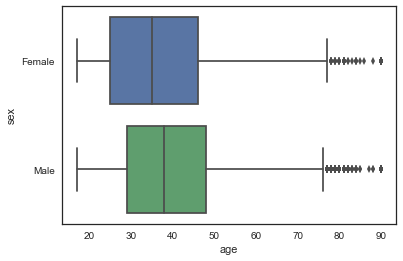

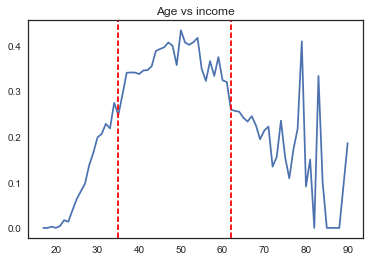

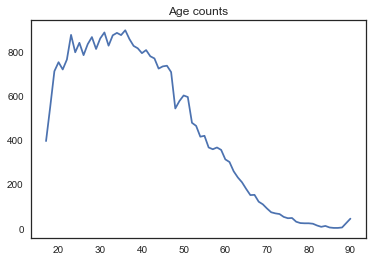

working age
no     0.118562
yes    0.356375
Name: inc, dtype: float64

In [4]:
#starting with age

#Quick stats about the age column
print(df.groupby('sex')['age'].describe())
sns.boxplot(x = 'age', y = 'sex', data = df)
plt.show()

# The males in the data are a bit older than the females, this will have implications on the 'working age' feature

# Creating grouped data to build an age range feature
x = df.groupby('age')['inc'].mean()
y = df['age'].value_counts().sort_index()

#This plot and the bars show my 'working age' range where earners have the highest chance of making over $50k
plt.plot(x)
plt.title('Age vs income')
plt.axvline(35, color = 'r', linestyle = '--')
plt.axvline(62, color = 'r', linestyle = '--')
plt.show()

#The histogram was kind of messy looking so I used a line plot instead
plt.plot(y)
plt.title('Age counts')
plt.show()

#Creating a feature
df['working age'] = 'no'
df.loc[((df.age >= 35) & (df.age <= 62)), 'working age'] = 'yes'
df.groupby('working age')['inc'].mean()

Age by itself provides a decent feature but I will be combining it with other variables below and it will be a lot more useful as part of a multi-variable feature.

Ultimately I think the second feature ('working age male') is a bit stronger than the original age feature.

# Workclass

In [5]:
# next is 'workclass'

# Private is the main work listed here so if we can split that up and find some tendencies it should make the model
# better at predicting things

print(df.groupby(['workclass'])['inc'].mean())
print('-'*40)
print(df.workclass.value_counts())

#creating levels based on work groups(government, self employed, other - still working and other)
df['worktype'] = 'Other'

df.loc[
    ((df.workclass == '?') | 
     (df.workclass == 'Private') | 
     (df.workclass == 'Self-emp-not-inc')),'worktype'
] = 'Other - still working'

df.loc[(df.workclass == 'Self-emp-inc'),'worktype'
] = 'Self Employed'

df.loc[((df.workclass == 'Federal-gov') | 
        (df.workclass == 'Local-gov') | 
        (df.workclass == 'State-gov')),'worktype'
] = 'Governmental'

print('-'*40)
print(df.groupby(['worktype'])['inc'].mean())

workclass
?                   0.104031
Federal-gov         0.386458
Local-gov           0.294792
Never-worked        0.000000
Private             0.218673
Self-emp-inc        0.557348
Self-emp-not-inc    0.284927
State-gov           0.271957
Without-pay         0.000000
Name: inc, dtype: float64
----------------------------------------
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
----------------------------------------
worktype
Governmental             0.308205
Other                    0.000000
Other - still working    0.217117
Self Employed            0.557348
Name: inc, dtype: float64


It is important to keep the 'Never-worked' and 'Without-pay' people since it is a strong predictor, but I wanted to make it it's own separate group since it was dragging down the other two non sorted classes(private, ?). 

It also seems(based on the data above) that separating this by gender would also be important.

Since 'Private' makes up almost 70% of the respondents would it be worth trying to dig into that subset separately to find some patterns?

# Education

education.num  education   
1              Preschool       0.000000
2              1st-4th         0.035714
3              5th-6th         0.048048
4              7th-8th         0.061920
5              9th             0.052529
6              10th            0.066452
7              11th            0.051064
8              12th            0.076212
9              HS-grad         0.159509
10             Some-college    0.190235
11             Assoc-voc       0.261216
12             Assoc-acdm      0.248360
13             Bachelors       0.414753
14             Masters         0.556587
15             Prof-school     0.734375
16             Doctorate       0.740920
Name: inc, dtype: float64


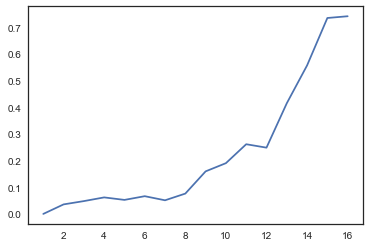

college
no     0.160529
yes    0.484567
Name: inc, dtype: float64


In [6]:
#Looking through the education data
print(df.groupby(['education.num', 'education'])['inc'].mean())

x = df.groupby('education.num')['inc'].mean()
plt.plot(x)
plt.show()

#setting a variable to indicate college level education
df['college'] = 'no'
df.loc[df['education.num'] >=13, 'college'] = 'yes'

print(df.groupby(['college'])['inc'].mean())

The major determinant here seems to be college. When I set that as a feature it's a pretty stark difference.

# Marital Status

In [7]:
#Marital status exploration
print(df['marital.status'].value_counts())
print('-'*40)

print(df.groupby('marital.status')['inc'].mean())
print('-'*40)

df['married'] = 'no'
df.loc[((df['marital.status'] == 'Married-AF-spouse') | (df['marital.status'] == 'Married-civ-spouse')),'married'] = 'yes'

print(df.groupby('married')['inc'].mean())

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64
----------------------------------------
marital.status
Divorced                 0.104209
Married-AF-spouse        0.434783
Married-civ-spouse       0.446848
Married-spouse-absent    0.081340
Never-married            0.045961
Separated                0.064390
Widowed                  0.085599
Name: inc, dtype: float64
----------------------------------------
married
no     0.064856
yes    0.446830
Name: inc, dtype: float64


In [8]:
print(df.groupby('inc')['marital.status'].value_counts())
print('-'*50)
print(df.groupby('inc')['relationship'].value_counts())
print('-'*50)
print(df.groupby('marital.status')['relationship'].value_counts())
print('-'*50)

df['civ_husband'] = 0
df.loc[
    (df['marital.status'] == 'Married-civ-spouse') & (df.relationship == 'Husband'),
    'civ_husband'
] = 1

df.groupby('civ_husband')['inc'].mean()

inc  marital.status       
0    Never-married            10192
     Married-civ-spouse        8284
     Divorced                  3980
     Separated                  959
     Widowed                    908
     Married-spouse-absent      384
     Married-AF-spouse           13
1    Married-civ-spouse        6692
     Never-married              491
     Divorced                   463
     Widowed                     85
     Separated                   66
     Married-spouse-absent       34
     Married-AF-spouse           10
Name: marital.status, dtype: int64
--------------------------------------------------
inc  relationship  
0    Not-in-family     7449
     Husband           7275
     Own-child         5001
     Unmarried         3228
     Other-relative     944
     Wife               823
1    Husband           5918
     Not-in-family      856
     Wife               745
     Unmarried          218
     Own-child           67
     Other-relative      37
Name: relationship, dtype: 

civ_husband
0    0.099448
1    0.448574
Name: inc, dtype: float64

It would seem that being married and living with your spouse seems to have a strong correlation to making over 50k, and it is slightly better than the more fine tuned civ_husband feature.

# Occupation

In [9]:
print(df.occupation.value_counts())
print('-'*40)

print(df.groupby('occupation')['inc'].mean())
print('-'*40)

#separating out occupations by collar color(that's fun to say)
df['collar'] = 'blue'
df.loc[
    ((df.occupation == 'Exec-managerial') | 
     (df.occupation == 'Prof-specialty') | 
     (df.occupation == 'Sales') | 
     (df.occupation == 'Tech-support') | 
     (df.occupation == 'Adm-clerical')),
    'collar'
] = 'white'

df.groupby('collar')['inc'].mean()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64
----------------------------------------
occupation
?                    0.103635
Adm-clerical         0.134483
Armed-Forces         0.111111
Craft-repair         0.226641
Exec-managerial      0.484014
Farming-fishing      0.115694
Handlers-cleaners    0.062774
Machine-op-inspct    0.124875
Other-service        0.041578
Priv-house-serv      0.006711
Prof-specialty       0.449034
Protective-serv      0.325116
Sales                0.269315
Tech-support         0.304957
Transport-moving     0.200376
Name: inc, dtype: float64
----------------------------------------


collar
blue     0.140001
white    0.338287
Name: inc, dtype: float64

Exec-managerial obviously takes the cake here, lets organize this into white collar and blue collar(everything non-white collar) jobs.

# Relationship

In [10]:
#Relationship issues
print(df.relationship.value_counts())
print('-'*40)
print(df.groupby('relationship')['inc'].mean())

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64
----------------------------------------
relationship
Husband           0.448571
Not-in-family     0.103070
Other-relative    0.037717
Own-child         0.013220
Unmarried         0.063262
Wife              0.475128
Name: inc, dtype: float64


After googling I can't find a good explanation for this column, but upon quick analysis it seems this category doesn't offer much more than the marital status column previously. Would it be worth trying to tie in this category and the 'marital status' category?

# Race

In [11]:
#Playing the race card

print(df.race.value_counts())
print('-'*40)
print(df.groupby('race')['inc'].mean())
print('-'*40)

#creating a group for whites and asians vs the rest
df['White or Asian'] = 'no'
df.loc[
    ((df.race == 'White') | (df.race == 'Asian-Pac-Islander')),'White or Asian'
] = 'yes'

print(df.groupby('White or Asian')['inc'].mean())

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64
----------------------------------------
race
Amer-Indian-Eskimo    0.115756
Asian-Pac-Islander    0.265640
Black                 0.123880
Other                 0.092251
White                 0.255860
Name: inc, dtype: float64
----------------------------------------
White or Asian
no     0.120885
yes    0.256212
Name: inc, dtype: float64


White and Asian/Pacific Islanders seem to have the best chance of making over 50k. The correlation is not super strong though so I might try and combine this with gender or something later on.

# Sex

In [12]:
#Sex sells
df.groupby('sex')['inc'].mean()

sex
Female    0.109461
Male      0.305737
Name: inc, dtype: float64

It seems fairly obvious(even before the analysis above) that men have a better chance of making over 50k than women do. It seems a bit simplistic though to just say that men make more than women. Race and Gender seem like they are more intertwined and nuanced than simply one or the other.

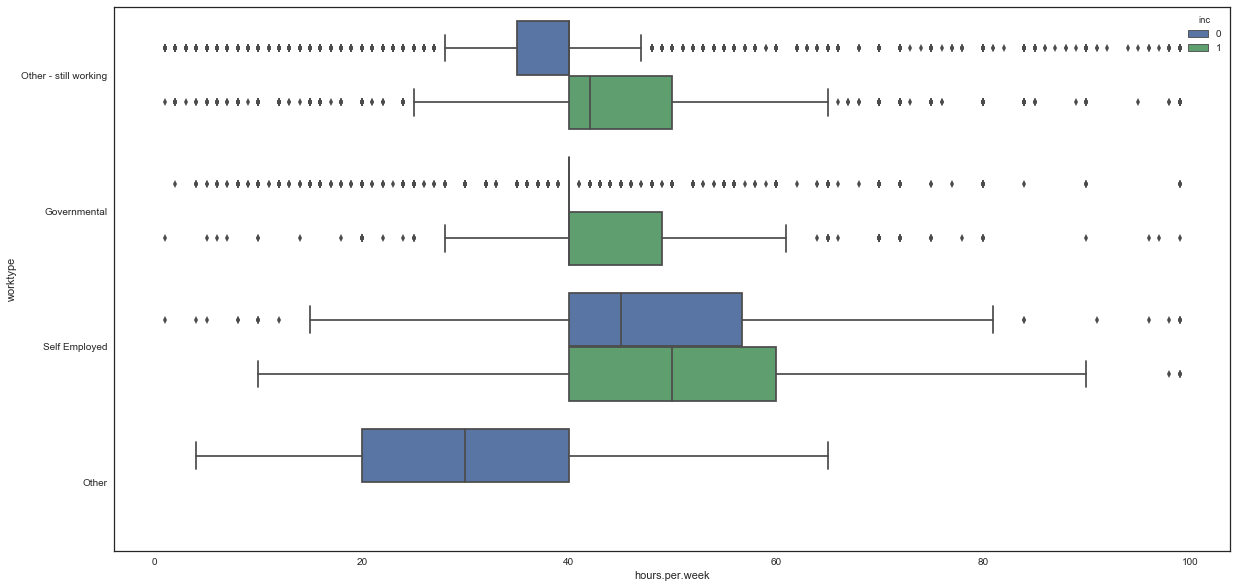

In [35]:
plt.figure(figsize=(20,10))
sns.boxplot(x='hours.per.week', y = 'worktype', hue = 'inc', data = df)

# Hours per week

hours
0    0.088978
1    0.284292
Name: inc, dtype: float64


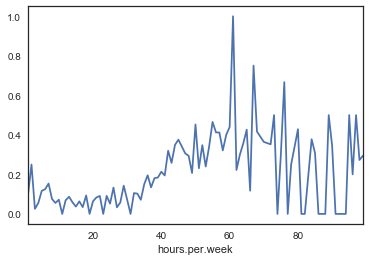

In [14]:
df.groupby('hours.per.week')['inc'].mean().plot()
df['hours'] = 0
df.loc[
    ((df['hours.per.week'] >= 38)), #& (df['hours.per.week'] <= 50)),
    'hours'
] = 1
print(df.groupby('hours')['inc'].mean())

#Check out full time vs part time

In [38]:
df['full-time'] = 'no'

df.loc[
    ((df['hours.per.week'] >= 35)),
    'full-time'
] = 'yes'

print(df.groupby('full-time')['inc'].mean())

full-time
no     0.069318
yes    0.276299
Name: inc, dtype: float64


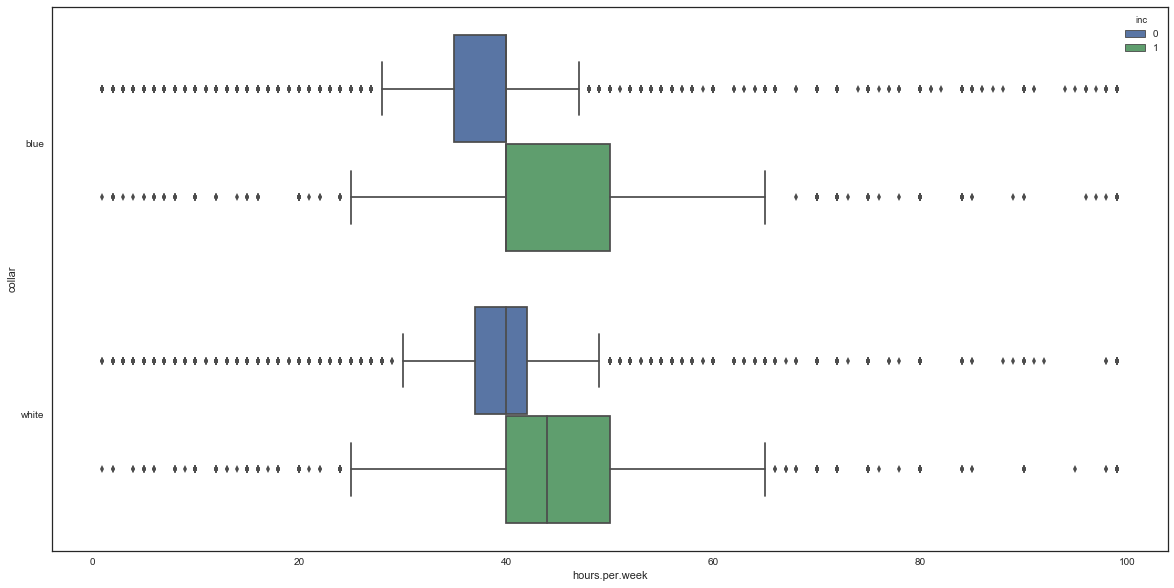

In [15]:
plt.figure(figsize = (20,10))
sns.boxplot(x = 'hours.per.week', y = 'collar', hue = 'inc', data = df)

While it is clear that men work more hours per week than women, there was suprisingly little difference in hours per week worked by workclass. Overall hours per week seems to be correlated to money earned but not necessarily driving it(since the hours themselves seem more of a byproduct of education level/job type and age). 

It seems like an interesting feature to be built would combine occupation and hours worked or education and hours worked to see what the differences were.

# Native Country

In [16]:
# the last column is native country

# having trouble finding a good way to build this feature, US is dominant population wise but liklihood of over 50k 
# is not too much bigger than all other countries, run a ttest?

df['native.country'].value_counts()
# The US makes up 90% of respondents...seems like that should factor in heavily, and that maybe I should break down
# the US data a bit more by itself.


United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                      

In [17]:
print(df.groupby('native.country')['inc'].mean().sort_values(ascending = False))
print('-'*40)

df['developed'] = 'no'

df.loc[
    ((df['native.country'] == 'Canada') |
    (df['native.country'] == 'China') |
     (df['native.country'] == 'England') |
     (df['native.country'] == 'France') |
     (df['native.country'] == 'Germany') |
     (df['native.country'] == 'Greece') |
     (df['native.country'] == 'India') |
     (df['native.country'] == 'Italy') |
     (df['native.country'] == 'Japan') |
     (df['native.country'] == 'Iran') |
     (df['native.country'] == 'Taiwan') |
     (df['native.country'] == 'United-States')),
    'developed'
] = 'yes'

df.groupby('developed')['inc'].mean()

native.country
Iran                          0.418605
France                        0.413793
India                         0.400000
Taiwan                        0.392157
Japan                         0.387097
Yugoslavia                    0.375000
Cambodia                      0.368421
Italy                         0.342466
England                       0.333333
Canada                        0.322314
Germany                       0.321168
Philippines                   0.308081
Hong                          0.300000
Greece                        0.275862
China                         0.266667
Cuba                          0.263158
?                             0.250429
Scotland                      0.250000
United-States                 0.245835
Hungary                       0.230769
Ireland                       0.208333
South                         0.200000
Poland                        0.200000
Thailand                      0.166667
Ecuador                       0.142857
Jamaica   

developed
no     0.151104
yes    0.248532
Name: inc, dtype: float64

This is kind of a mediocre split. Something I'm wondering. Since the US makes up 90% or so of respondents. Is it worth almost treating it like a separate column. So in the model it would go through two checks. The first to see if they are from the US, if yes then you are evaluated against feature A, if no then you are evaluated against feature B(a separate feature built by looking at all of the other countries in one group separate from the US.

In [18]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,inc,working age,worktype,college,married,civ_husband,collar,White or Asian,hours,developed
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K,0,no,Other - still working,no,no,0,blue,yes,1,yes
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,0,no,Other - still working,no,no,0,white,yes,0,yes
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K,0,no,Other - still working,no,no,0,blue,no,1,yes
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,0,yes,Other - still working,no,no,0,blue,yes,1,yes
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,0,yes,Other - still working,no,no,0,white,yes,1,yes


# Multivariate features

In [19]:
# Looking at these two variables for a possible combination
print(df.groupby(['collar', 'worktype'])['inc'].mean())
print('-'*60)
print(df.groupby(['collar', 'worktype'])['inc'].value_counts())

df['white collar professional'] = 0
df.loc[
    (((df.worktype == 'Governmental') | 
     (df.worktype == 'Other - still working') | 
     (df.worktype == 'Self Employed')) & 
     (df.collar == 'white')),
    'white collar professional'
] = 1

print(df.groupby('white collar professional')['inc'].mean())

collar  worktype             
blue    Governmental             0.227910
        Other                    0.000000
        Other - still working    0.128384
        Self Employed            0.329004
white   Governmental             0.347350
        Other                    0.000000
        Other - still working    0.316930
        Self Employed            0.616949
Name: inc, dtype: float64
------------------------------------------------------------
collar  worktype               inc
blue    Governmental           0       1101
                               1        325
        Other                  0         18
        Other - still working  0      12492
                               1       1840
        Self Employed          0        155
                               1         76
white   Governmental           0       1909
                               1       1016
        Other                  0          3
        Other - still working  0       8703
                            

In [20]:
# A feature built off the two most likely race indicators and further segmented by gender
print(df.groupby(['race', 'sex'])['inc'].mean())

df['white_male'] = 'no'
df.loc[
    ((df.race == 'White') | (df.race == 'Asian-Pac-Islander')) & (df.sex == 'Male'),
    'white_male'
] = 'yes'

print(df.groupby('white_male')['inc'].mean())

race                sex   
Amer-Indian-Eskimo  Female    0.100840
                    Male      0.125000
Asian-Pac-Islander  Female    0.124277
                    Male      0.336219
Black               Female    0.057878
                    Male      0.189293
Other               Female    0.055046
                    Male      0.117284
White               Female    0.118954
                    Male      0.317565
Name: inc, dtype: float64
white_male
no     0.119663
yes    0.318216
Name: inc, dtype: float64


In [36]:
# Looking at the combination of going to college and coming from a developed country
df['third.world.college'] = 'no'

df.loc[
    ((df.college == 'yes') & 
    (df.developed == 'no')),
    'third.world.college'
] = 'yes'
df.groupby('third.world.college')['inc'].mean()

third.world.college
no     0.238263
yes    0.384480
Name: inc, dtype: float64

In [22]:
df.groupby('first.world.college')['inc'].mean()

first.world.college
no     0.165596
yes    0.492133
Name: inc, dtype: float64

That seems like a pretty good split

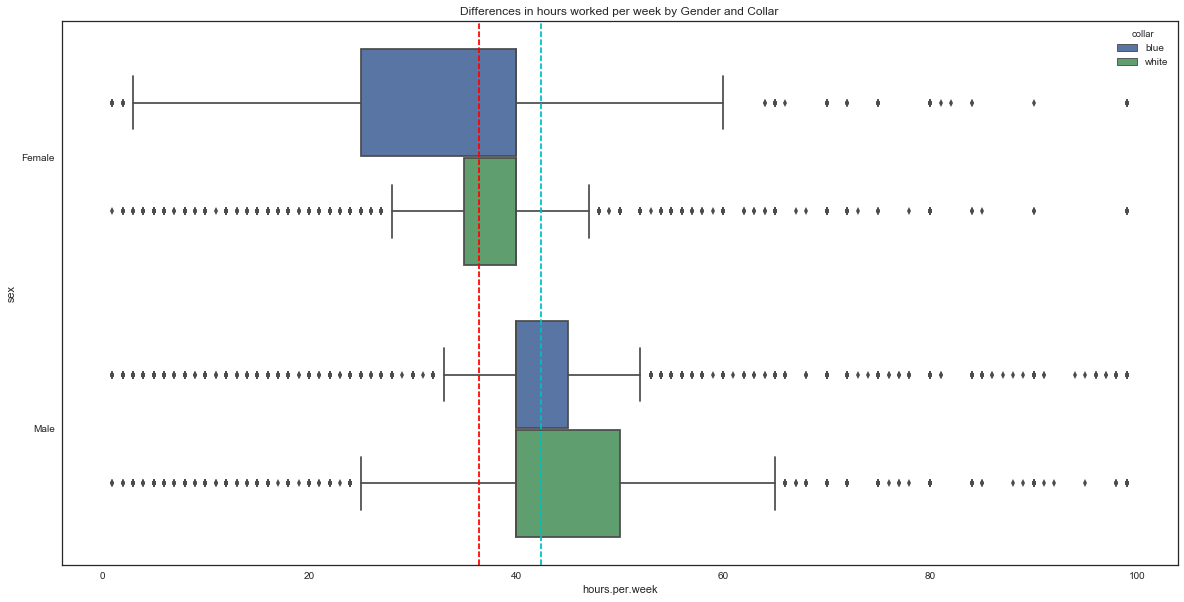

sex
Female    36.410361
Male      42.428086
Name: hours.per.week, dtype: float64
count    21790.000000
mean        42.428086
std         12.119755
min          1.000000
25%         40.000000
50%         40.000000
75%         49.000000
max         99.000000
Name: hours.per.week, dtype: float64
----------------------------------------
count    10771.000000
mean        36.410361
std         11.811300
min          1.000000
25%         30.000000
50%         40.000000
75%         40.000000
max         99.000000
Name: hours.per.week, dtype: float64
----------------------------------------
Ttest_indResult(statistic=42.50952506734037, pvalue=0.0)


In [23]:
#Hours worked per week

plt.figure(figsize=(20,10))
plt.title('Differences in hours worked per week by Gender and Collar')
sns.boxplot(x = df['hours.per.week'], y = df['sex'], hue = df['collar'])
plt.axvline(36.4, color = 'r', linestyle = '--')
plt.axvline(42.4, color = 'c', linestyle = '--')
plt.show()
print(df.groupby('sex')['hours.per.week'].mean())

#Breaking this up by gender gets interesting
print(df.loc[(df['sex'] == 'Male'),'hours.per.week'].describe())
print('-'*40)
print(df.loc[(df['sex'] == 'Female'), 'hours.per.week'].describe())
print('-'*40)

#Lets see if those differences are significant
print(stats.ttest_ind(
        df[df['sex'] == 'Male']['hours.per.week'].dropna(),
        df[df['sex'] == 'Female']['hours.per.week'].dropna()
    ))

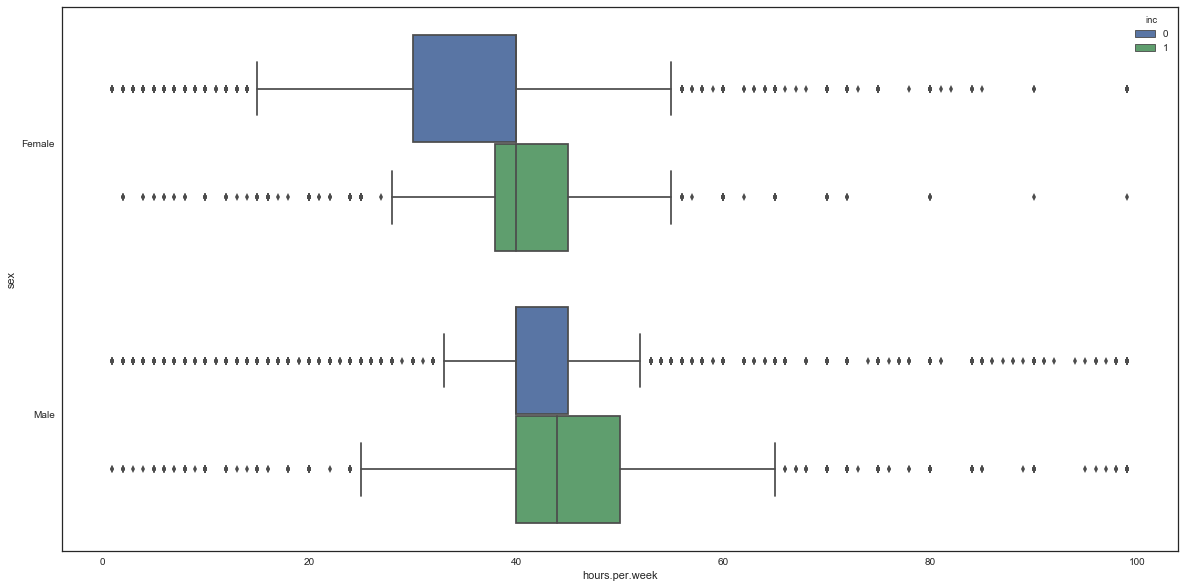

In [24]:
#By swapping randome combinations of variables into the y and hue variables we can get a lot of interesting views
# of the data
plt.figure(figsize=(20,10))
sns.boxplot(x = 'hours.per.week', y = 'sex', hue = 'inc', data = df)

Axes(0.125,0.125;0.775x0.755)
Axes(0.125,0.125;0.775x0.755)
Axes(0.125,0.125;0.775x0.755)


working.age.male
no     0.152751
yes    0.451768
Name: inc, dtype: float64

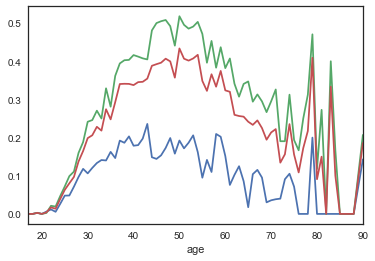

In [25]:
#creating separate dataframes for testing
df_w = df.loc[
    (df.sex == 'Female'), :
]

df_m = df.loc[
    (df.sex == 'Male'), :
]

# I think these three lines are fascinating. You can see that during the previously discussed 'working age' period 
# that males have a much higher earning potential. This needs to be factored in.
print(df_w.groupby('age')['inc'].mean().plot()) # Female line is Blue
print(df_m.groupby('age')['inc'].mean().plot()) # Male line is Green
print(df.groupby('age')['inc'].mean().plot())   # Total line is Red

#Building a feature for working age males(40-60), notice I have also changed the age range around for just men
df['working.age.male'] = 'no'
df.loc[
    ((df.age >= 38) & 
     (df.age <= 60) & 
     (df.sex == 'Male')
    ), 'working.age.male'
] = 'yes'

df.groupby('working.age.male')['inc'].mean()

In [26]:
#creating a feature that looks at only men in government/self employed roles

df['prof_male'] = 'no'
df.loc[
    (((df.worktype == 'Governmental') | 
      (df.worktype == 'Self Employed')) & 
     (df.sex == 'Male')),
    'prof_male'
] = 'yes'

df.groupby('prof_male')['inc'].mean()

prof_male
no     0.214667
yes    0.445167
Name: inc, dtype: float64

# Final list of features

In [39]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income', 'inc', 'working age', 'worktype', 'college', 'married',
       'civ_husband', 'collar', 'White or Asian', 'hours', 'developed',
       'white collar professional', 'white_male', 'first.world.college',
       'working.age.male', 'prof_male', 'third.world.college', 'full-time'],
      dtype='object')

In [40]:
df_feats = df[['age', 
               'workclass', 
               'education', 
               'education.num',
               'marital.status',
               'occupation',
               'relationship',
               'race',
               'sex',
               'hours.per.week',
               'native.country',
               'working age',
               'worktype',
               'college',
               'married',
               'civ_husband',
               'collar',
               'White or Asian',
               'hours',
               'developed',
               'white collar professional',
               'white_male',
               'first.world.college',
               'working.age.male',
               'prof_male',
               'full-time',
               'inc']           
]

In [41]:
df_feats.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,hours.per.week,native.country,working age,worktype,college,married,civ_husband,collar,White or Asian,hours,developed,white collar professional,white_male,first.world.college,working.age.male,prof_male,full-time,inc
0,90,?,HS-grad,9,Widowed,?,Not-in-family,White,Female,40,United-States,no,Other - still working,no,no,0,blue,yes,1,yes,0,no,no,no,no,yes,0
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,18,United-States,no,Other - still working,no,no,0,white,yes,0,yes,1,no,no,no,no,no,0
2,66,?,Some-college,10,Widowed,?,Unmarried,Black,Female,40,United-States,no,Other - still working,no,no,0,blue,no,1,yes,0,no,no,no,no,yes,0
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,40,United-States,yes,Other - still working,no,no,0,blue,yes,1,yes,0,no,no,no,no,yes,0
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,40,United-States,yes,Other - still working,no,no,0,white,yes,1,yes,1,no,no,no,no,yes,0


In [43]:
#Categorizing the newly built features

#lets focus on the ones more 'social' in nature first

 ch = df_feats.groupby('civ_husband')['inc'].mean() 
 ma = df_feats.groupby('married')['inc'].mean()
 wa = df_feats.groupby('White or Asian')['inc'].mean()
 wm = df_feats.groupby('white_male')['inc'].mean()
 wam = df_feats.groupby('working.age.male')['inc'].mean()
 pm = df_feats.groupby('prof_male')['inc'].mean()
se = df_feats.groupby('sex')['inc'].mean()
 de = df_feats.groupby('developed')['inc'].mean()

#And these are a bit more professional in nature
 wcp = df_feats.groupby('white collar professional')['inc'].mean()
 fwc = df_feats.groupby('first.world.college')['inc'].mean()
 wt = df_feats.groupby('worktype')['inc'].mean()
 ce = df_feats.groupby('college')['inc'].mean()
 cr = df_feats.groupby('collar')['inc'].mean()
 wo = df_feats.groupby('working age')['inc'].mean()
ho = df_feats.groupby('hours')['inc'].mean()
ft = df_feats.groupby('full-time')['inc'].mean()

Comparing similar categories below for clarity purposes.

In [31]:
print(ch)
print(ma)

civ_husband
0    0.099448
1    0.448574
Name: inc, dtype: float64
married
no     0.064856
yes    0.446830
Name: inc, dtype: float64


Married seems like it will suffice

In [32]:
print(wa)
print(wm)
print(wam)
print(wo)
print(pm)

White or Asian
no     0.120885
yes    0.256212
Name: inc, dtype: float64
white_male
no     0.119663
yes    0.318216
Name: inc, dtype: float64
working.age.male
no     0.152751
yes    0.451768
Name: inc, dtype: float64
working age
no     0.118562
yes    0.356375
Name: inc, dtype: float64
prof_male
no     0.214667
yes    0.445167
Name: inc, dtype: float64


The 'White or Asian' feature just doesn't have a very strong split, 'white_male' seems to be better. Working age also seems alright but 'working age male' is better. I might just use working age male in place of all of them.

In [33]:
print(wcp)
print(wt)
print(cr)

white collar professional
0    0.139975
1    0.338348
Name: inc, dtype: float64
worktype
Governmental             0.308205
Other                    0.000000
Other - still working    0.217117
Self Employed            0.557348
Name: inc, dtype: float64
collar
blue     0.140001
white    0.338287
Name: inc, dtype: float64


I think worktype is still the best indicator, especially if I can use it as a weight instead of a straight yes/no variable

In [34]:
print(ce)
print(fwc)
print(de)

college
no     0.160529
yes    0.484567
Name: inc, dtype: float64
first.world.college
no     0.165596
yes    0.492133
Name: inc, dtype: float64
developed
no     0.151104
yes    0.248532
Name: inc, dtype: float64


first.world.college seems like the strongest indicator

In [44]:
print(ho)
print(ft)

hours
0    0.088978
1    0.284292
Name: inc, dtype: float64
full-time
no     0.069318
yes    0.276299
Name: inc, dtype: float64


the full time seems like a better indicator both because it's close to the 'hours' feature and also because it is a more natural split. More than 35 hours equates to full time work and less would be part time, this would probably reflect better upon test data and prevent over fitting(my original setting of the arbitrary lower and upper limits of 'hours' seems like a type of over-fitting.

In [46]:
#building a data frame with the final features that I would put into my model
df_final = df_feats[['married', 'working.age.male', 'worktype', 'first.world.college', 'full-time', 'inc']]

The only issue I see above so far is that all the final features except for 'worktype' are binary. The 'worktype' feature would work better if it was able to be weighted instead of just a yes or no checkoff.

In [50]:
#lets do a quick run through of the features
df_final.loc[
    ((df_final.married == 'yes') & 
    (df_final['working.age.male'] == 'yes') & 
    ((df_final.worktype == 'Governmental') | 
    (df_final.worktype == 'Self Employed')) & 
     (df['first.world.college'] == 'yes') & 
     (df['full-time'] == 'yes')),
    'inc'
].mean()

0.80601092896174864